# Лабораторная работа 2. Визуализация градиентного спуска. Ландшафты потерь. Оптимайзеры.



In [1]:
# готовим функцию для красивой отрисовки градиента
import numpy as np
import matplotlib.pyplot as plt

def show_contours(objective,
                  x_lims=[-200.0, 202.0],
                  y_lims=[-200.0, 202.0],
                  x_ticks=100,
                  y_ticks=100):
    x_step = (x_lims[1] - x_lims[0]) / x_ticks
    y_step = (y_lims[1] - y_lims[0]) / y_ticks
    X, Y = np.mgrid[x_lims[0]:x_lims[1]:x_step, y_lims[0]:y_lims[1]:y_step]
    res = []
    for x_index in range(X.shape[0]):
        res.append([])
        for y_index in range(X.shape[1]):
            x_val = X[x_index, y_index]
            y_val = Y[x_index, y_index]
            res[-1].append(objective(np.array([[x_val, y_val]]).T))
    res = np.array(res)
    plt.figure(figsize=(7,7))
    plt.contour(X, Y, res, 100)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

In [2]:
# расcчитаем градиентный спуск для фунции для 10 cумма(x^2), x = тензор 1 на 2. Инициализирован значением 8
import torch

# тензор
x = torch.tensor(
    [200.,200.], requires_grad=True)

# сюда будем складывать значения тензора x при каждом шаге градиентного спуска
var_history = []

# сюда будем складывать значения функции при каждом шаге градиентного спуска
fn_history = []

# определяем функцию.
def function_parabola(variable):
    return 10 * (variable ** 2).sum()

# считаем шаг градиентного спуска
lr = 0.01
def make_gradient_step(function, variable):
    function_result = function(variable)
    function_result.backward()
    variable.data -= lr * variable.grad
    variable.grad.zero_()

# реализуем градиентный спуск, думаем, что за 500 шагов справимся, и найдем минимум функции.
for i in range(500):
    var_history.append(x.data.cpu().numpy().copy())
    fn_history.append(function_parabola(x).data.cpu().numpy().copy())
    make_gradient_step(function_parabola, x)

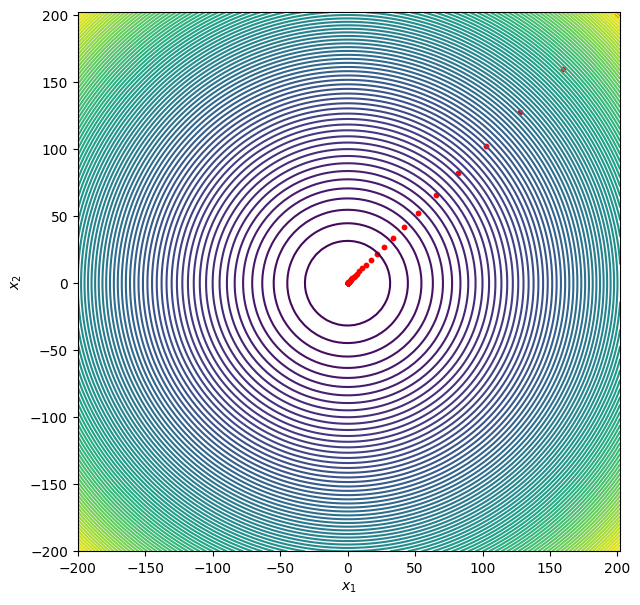

In [3]:
show_contours(function_parabola)
plt.scatter(np.array(var_history)[:,0], np.array(var_history)[:,1], s=10, c='r');

## Задание 1. Сделайте трехмерную визуализацию сходимости градиентного спуска. Нарисуйте поверхность функции двух переменных для которой осуществлялся поиск минимума методом градиентного спуска. Отдельными точками другого цвета изобразите позиции которые рассматривались на каждом шаге градиентного спуска.

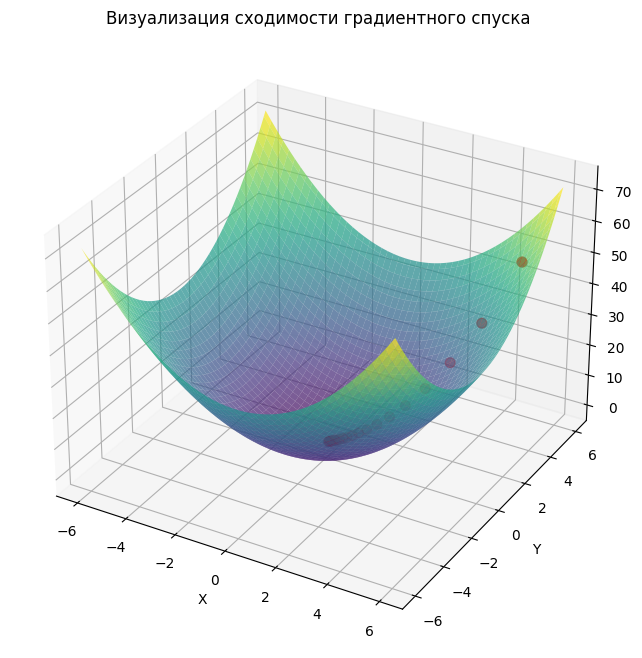

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Функция двух переменных (например, кв-ая)
def func(x, y):
    return x**2 + y**2

# Градиент функции
def gradient(x, y):
    return 2*x, 2*y

# Градиентный спуск
def gradient_descent(learning_rate=0.1, num_iterations=20):
    x, y = 5, 5  # Начальная точка
    trajectory = [(x, y)]

    for _ in range(num_iterations):
        grad_x, grad_y = gradient(x, y)
        x -= learning_rate * grad_x
        y -= learning_rate * grad_y
        trajectory.append((x, y))

    return np.array(trajectory)

# Выполнение градиентного спуска
trajectory = gradient_descent()

# Создание сетки значений для построения поверхности
x = np.linspace(-6, 6, 100)
y = np.linspace(-6, 6, 100)
X, Y = np.meshgrid(x, y)
Z = func(X, Y)

# Построение поверхности
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)

# Построение траектории градиентного спуска
ax.scatter(trajectory[:, 0], trajectory[:, 1], func(trajectory[:, 0], trajectory[:, 1]), color='red', s=50)

# Подписи осей
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('Визуализация сходимости градиентного спуска')
plt.show()


## Задание 2. Для своего кода лабораторной работы №1 примените три разных оптимайзера. Постройте графики зависимости величины функции потерь от номера эпохи для всех трех оптимайзеров на одном графике сначала для обучающей выборки, потом для тестовой.

100%|██████████| 182040794/182040794 [00:10<00:00, 17650709.99it/s]


100%|██████████| 64275384/64275384 [00:05<00:00, 11549153.82it/s]


Training with Adam optimizer...
Training with SGD optimizer...
Training with RMSprop optimizer...


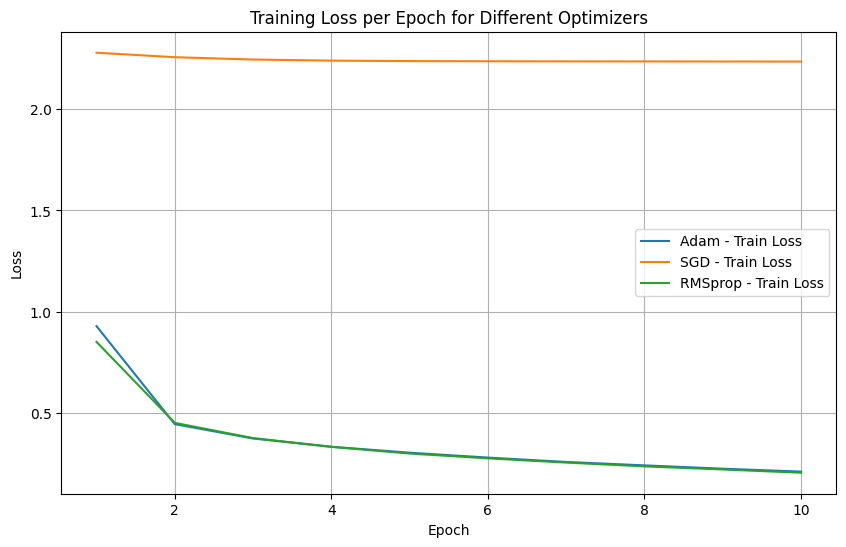

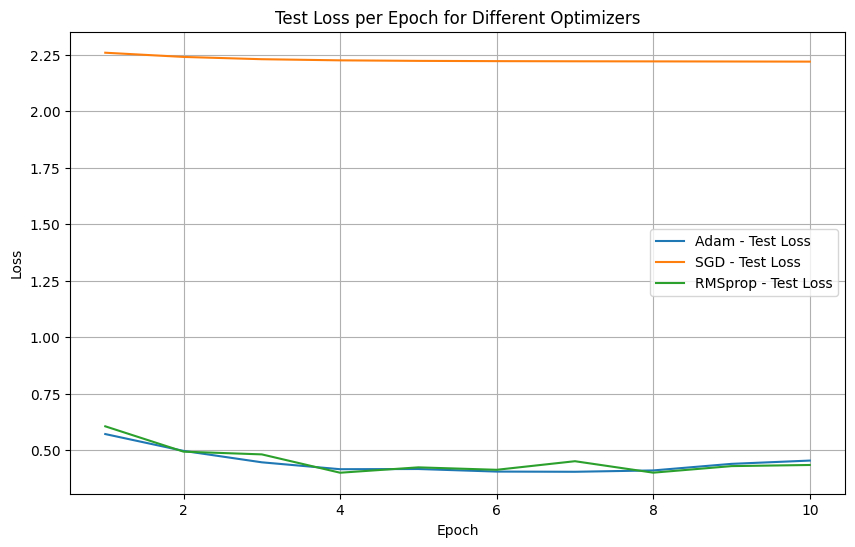

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Загрузка и переработка данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_dataset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2. Определение модели LeNet-5
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 3. Определение трех оптимизаторов
optimizers = {
    "Adam": optim.Adam,
    "SGD": optim.SGD,
    "RMSprop": optim.RMSprop
}

# 4. Функция для обучения модели с заданным оптимизатором
def train_with_optimizer(optimizer_name, model, train_loader, test_loader, num_epochs=5):
    optimizer = optimizers[optimizer_name](model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Оценка на тестовом наборе
        model.eval()
        running_test_loss = 0.0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()

        test_loss = running_test_loss / len(test_loader)
        test_losses.append(test_loss)

    return train_losses, test_losses

# 5. Сравнение оптимизаторов
num_epochs = 10  # Количество эпох
results = {}

for opt_name in optimizers:
    print(f"Training with {opt_name} optimizer...")
    model = LeNet5().to(device)
    train_losses, test_losses = train_with_optimizer(opt_name, model, train_loader, test_loader, num_epochs)
    results[opt_name] = {"train_losses": train_losses, "test_losses": test_losses}

# 6. Построение графиков
# График потерь на обучающей выборке для разных оптимизаторов
plt.figure(figsize=(10, 6))
for opt_name in optimizers:
    plt.plot(range(1, num_epochs + 1), results[opt_name]['train_losses'], label=f'{opt_name} - Train Loss')
plt.title('Training Loss per Epoch for Different Optimizers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# График потерь на тестовой выборке для разных оптимизаторов
plt.figure(figsize=(10, 6))
for opt_name in optimizers:
    plt.plot(range(1, num_epochs + 1), results[opt_name]['test_losses'], label=f'{opt_name} - Test Loss')
plt.title('Test Loss per Epoch for Different Optimizers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Задание 3. Изучите статью https://habr.com/ru/companies/skillfactory/articles/536606/. Попробуйте воспроизвести ее результаты в своем коде. Если не получится сделать анимацию, можно те же графики оставить статическими.

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


<ipython-input-12-21ff80376311>:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w2[5][250] = w_a
<ipython-input-12-21ff80376311>:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w2[5][251] = w_b


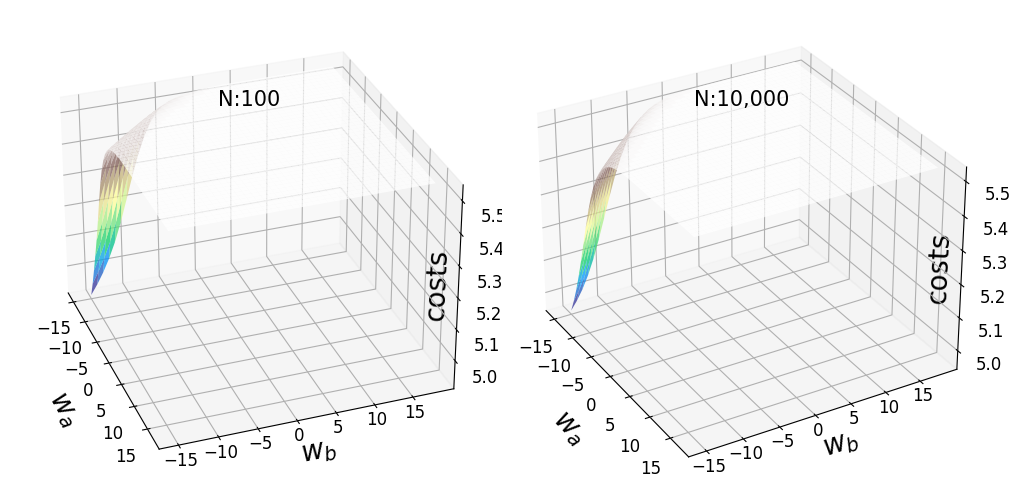

In [12]:
# Установка необходимых библиотек
!pip install torch torchvision matplotlib celluloid

# Импорт библиотек
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torchvision
from torchvision import transforms
from sklearn.preprocessing import OneHotEncoder
from scipy.special import expit
from celluloid import Camera

# Трансформации для данных SVHN
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Загрузка датасета SVHN
train_dataset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_dataset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform)

# Преобразование данных в numpy массивы
X_train = train_dataset.data.reshape(-1, 32*32*3).astype(np.float32) / 255  # нормализация
y_train = train_dataset.labels.astype(np.float32)

# One-hot кодирование меток
oh = OneHotEncoder(categories='auto')
y_train_oh = oh.fit_transform(y_train.reshape(-1, 1)).toarray()

# Определение слоев сети
hidden_0 = 50
hidden_1 = 500

# Функция расчета потерь
def costs(x, y, w_a, w_b, seed_):
    np.random.seed(seed_)
    w0 = np.random.randn(hidden_0, 32*32*3)
    w1 = np.random.randn(hidden_1, hidden_0)
    w2 = np.random.randn(10, hidden_1)
    w2[5][250] = w_a
    w2[5][251] = w_b
    a0 = expit(w0 @ x.T)
    a1 = expit(w1 @ a0)
    pred = expit(w2 @ a1)
    return np.mean(np.sum((y - pred) ** 2, axis=0))

# Определение сетки
m1s = np.linspace(-15, 17, 40)
m2s = np.linspace(-15, 18, 40)
M1, M2 = np.meshgrid(m1s, m2s)

# Расчет потерь для сетки
zs_100 = np.array([costs(X_train[:100], y_train_oh[:100].T, np.array([[mp1]]), np.array([[mp2]]), 135)
                   for mp1, mp2 in zip(np.ravel(M1), np.ravel(M2))])
Z_100 = zs_100.reshape(M1.shape)

zs_10000 = np.array([costs(X_train[:10000], y_train_oh[:10000].T, np.array([[mp1]]), np.array([[mp2]]), 135)
                     for mp1, mp2 in zip(np.ravel(M1), np.ravel(M2))])
Z_10000 = zs_10000.reshape(M1.shape)

# Построение ландшафта потерь
fig = plt.figure(figsize=(10, 7.5))
ax0 = fig.add_subplot(121, projection='3d')
ax1 = fig.add_subplot(122, projection='3d')

fontsize_ = 20
labelsize_ = 12

# Настройка графиков
ax0.view_init(elev=30, azim=-20)
ax0.set_xlabel(r'$w_a$', fontsize=fontsize_, labelpad=9)
ax0.set_ylabel(r'$w_b$', fontsize=fontsize_, labelpad=-5)
ax0.set_zlabel("costs", fontsize=fontsize_, labelpad=-30)
ax0.tick_params(axis='x', pad=5, which='major', labelsize=labelsize_)
ax0.tick_params(axis='y', pad=-5, which='major', labelsize=labelsize_)
ax0.tick_params(axis='z', pad=5, which='major', labelsize=labelsize_)
ax0.set_title('N:100', y=0.85, fontsize=15)

ax1.view_init(elev=30, azim=-30)
ax1.set_xlabel(r'$w_a$', fontsize=fontsize_, labelpad=9)
ax1.set_ylabel(r'$w_b$', fontsize=fontsize_, labelpad=-5)
ax1.set_zlabel("costs", fontsize=fontsize_, labelpad=-30)
ax1.tick_params(axis='y', pad=-5, which='major', labelsize=labelsize_)
ax1.tick_params(axis='x', pad=5, which='major', labelsize=labelsize_)
ax1.tick_params(axis='z', pad=5, which='major', labelsize=labelsize_)
ax1.set_title('N:10,000', y=0.85, fontsize=15)

# Поверхности
ax0.plot_surface(M1, M2, Z_100, cmap='terrain', antialiased=True, cstride=1, rstride=1, alpha=0.75)
ax1.plot_surface(M1, M2, Z_10000, cmap='terrain', antialiased=True, cstride=1, rstride=1, alpha=0.75)
plt.tight_layout()
plt.show()


## Задание 4. В коде, полученном после выполнения задания 3, релизуйте по формулам один из оптимайзеров. Как изменится визуализация поиска минимума из тех же трех точек?